# Wide&Deep模型 模态I的Chamber4数据虚拟测量
(1)提取批次间信息(2)wide&deep模型，优化了代码的结构（3）keras的Model有多个输入

In [36]:
import pickle
import os
import tqdm as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils.functions_plot as PL

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Model, Input, Sequential
from keras.layers import Dense, Activation, Concatenate, concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

from scipy.spatial import distance_matrix

In [2]:
Train_data = pd.read_csv('./data phm 2016/Train_data_modeI_chamber4_mm.csv')
Test_data = pd.read_csv('./data phm 2016/Test_data_modeI_chamber4_mm.csv')
Train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
Test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
print(Train_data.shape, Test_data.shape)

(147701, 26) (30600, 26)


## 提取批次间特征：（与k近邻的状态变量初值距离，k近邻的MRR值）

In [3]:
def extract_status_features(data):
    status_cols = ['WAFER_ID','USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER', 'USAGE_OF_POLISHING_TABLE', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET']
    status_features = pd.DataFrame(columns=status_cols)
    y = pd.DataFrame(columns=['WAFER_ID', 'AVG_REMOVAL_RATE'])
    for wafer_id, group in data.groupby(by=['WAFER_ID']):
#         print(wafer_id)
        status_features = status_features.append(group.loc[:, status_cols].iloc[0])
        y = y.append(group.loc[:, ['WAFER_ID', 'AVG_REMOVAL_RATE']].iloc[0])
    status_features = status_features.set_index(['WAFER_ID'])
    y = y.set_index(['WAFER_ID'])
    
    return status_features, y

In [4]:
status_features_train, train_y = extract_status_features(Train_data)
status_features_train.drop(4167773580, axis=0, inplace=True) # Note: wafer_id=4167773580只划分了两个时段
train_y.drop(4167773580, axis=0, inplace=True)

status_features_test, test_y = extract_status_features(Test_data)
print(status_features_train.shape, status_features_test.shape, train_y.shape, test_y.shape)

(797, 6) (165, 6) (797, 1) (165, 1)


In [73]:
flag = False
if flag:
    ss = StandardScaler()
    train_y = ss.fit_transform(train_y)
    test_y = ss.transform(test_y)

In [5]:
def min_larger_than_zero(onerow):
    return onerow[onerow>0].min()
def idxmin_larger_than_zero(onerow):
    return onerow[onerow>0].idxmin()

In [6]:
def extract_batch_features(status_features:pd.DataFrame, y:pd.DataFrame):
    df = status_features.copy()
    dis = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    
    df_batch_features = pd.DataFrame(index=dis.index)
    df_batch_features['nn_dist'] = dis.apply(min_larger_than_zero, axis=1)
    df_batch_features['nn_dist_idx'] = dis.apply(idxmin_larger_than_zero, axis=1)
    df_batch_features['nn_MRR'] = y.loc[df_batch_features['nn_dist_idx']].values
    
    df_batch_features.drop(['nn_dist_idx'], axis=1, inplace=True)
    
    return df_batch_features

In [7]:
batch_features_train = extract_batch_features(status_features_train, train_y)
batch_features_test = extract_batch_features(status_features_test, test_y)
print(batch_features_train.shape, batch_features_test.shape)

(797, 2) (165, 2)


## 拼接特征
(1)LSTM/conv1d/BiLSTM分别读取然后运行文件

In [45]:
sae_features_train = pd.read_csv('./data phm 2016/LSTM_sae_features_train.csv')
sae_features_train = sae_features_train.set_index(['WAFER_ID'])

sae_features_test = pd.read_csv('./data phm 2016/LSTM_sae_features_test.csv')
sae_features_test = sae_features_test.set_index(['WAFER_ID'])

print(sae_features_train.shape, sae_features_test.shape)

(797, 15) (165, 15)


## wide&deep的两种结构
结构1和结构2的区别在于空间特征是否输入到Deep模型中，本次实验的Deep模型均是16个隐藏神经单元，输出是sigmoid函数

In [46]:
# 结构1
X_train = pd.merge(batch_features_train, sae_features_train, left_index=True, right_index=True)
X_test = pd.merge(batch_features_test, sae_features_test, left_index=True, right_index=True)
print(X_train.shape, X_test.shape)

(797, 17) (165, 17)


Model: "wide_and_deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 17)]         0                                            
__________________________________________________________________________________________________
deep_dense (Dense)              (None, 16)           288         deep_input[0][0]                 
__________________________________________________________________________________________________
deep_dense2 (Dense)             (None, 8)            136         deep_dense[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 17)]         0                                            
________________________________________________________________________________

16/16 [==============================] - 0s 704us/step - loss: 6.6739 - mse: 6.6739
Epoch 149/200
16/16 [==============================] - 0s 680us/step - loss: 6.7847 - mse: 6.7847
Epoch 150/200
16/16 [==============================] - 0s 743us/step - loss: 6.4531 - mse: 6.4531
Epoch 151/200
16/16 [==============================] - 0s 782us/step - loss: 6.5453 - mse: 6.5453
Epoch 152/200
16/16 [==============================] - 0s 679us/step - loss: 6.8430 - mse: 6.8430
Epoch 153/200
16/16 [==============================] - 0s 678us/step - loss: 5.7643 - mse: 5.7643
Epoch 154/200
16/16 [==============================] - 0s 680us/step - loss: 5.9565 - mse: 5.9565
Epoch 155/200
16/16 [==============================] - 0s 671us/step - loss: 7.7968 - mse: 7.7968
Epoch 156/200
16/16 [==============================] - 0s 693us/step - loss: 6.3501 - mse: 6.3501
Epoch 157/200
16/16 [==============================] - 0s 696us/step - loss: 6.3253 - mse: 6.3253
Epoch 158/200
16/16 [=============

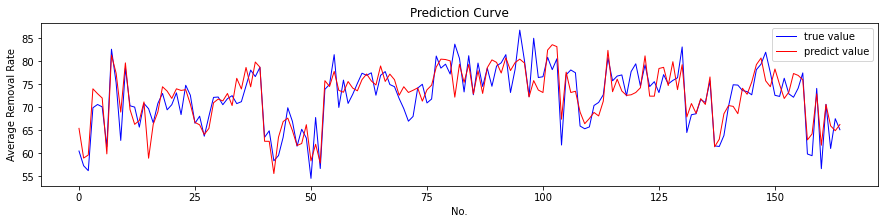

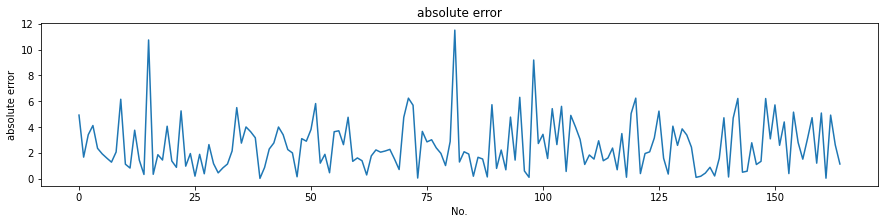

In [68]:
num_cell = 16 # (conv1d=33, LSTM=33, biLSTM=82)
mode_type = 0
if mode_type==0: # 结构1：wide输入时空特征
    wide_features_train = X_train.copy()
    wide_features_test = X_test.copy()
else:
    wide_features_train = batch_features_train.copy()
    wide_features_test = batch_features_test.copy()
    
# wide&deep

# 函数式API 功能API
deep_inp = Input(shape=(X_train.shape[1],), name='deep_input')
deep = Dense(num_cell, activation='relu', name='deep_dense')(deep_inp)

wide = Input(shape=(wide_features_train.shape[1],), name='wide_input')

#结合deep和input
concat = concatenate([wide, deep], name='concat_input')
output = Dense(1, name='output')(concat)

model = Model(inputs=[deep_inp, wide], outputs=[output], name='wide_and_deep_model')
print(model.summary())

# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, min_delta=0.5, min_lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mse'])
model.fit([X_train, wide_features_train], train_y, epochs=200, batch_size=50, callbacks=[reduce_lr])

y_test_pre = model.predict([X_test, wide_features_test])
PL.plot_predict_curve(test_y.values, y_test_pre)

In [ ]:
# 问题是模型的mse不能降低了
# adamax  epoch=200 